In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace

In [2]:
import pickle
import numpy as np
import os
import argparse
import datetime
import time
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()

import utils
from reacher_def import RotReacherEnv

In [7]:
def create_training_data(n_train=2000, n_val=200, n_steps=42, xml_name='rot_reacher_humanlike.xml',
                         max_action=0.1, render_on=False):

    ### create folder with current date and time where data and metadata are stored.
    dir_name = "training_data_{0}".format(datetime.datetime.now().strftime("%d_%H_%M_%S"))
    os.mkdir(dir_name)
    training_dir = os.path.realpath(dir_name)

    ### fetch input arguments for better documentation and store them in the training directory
    args = dict(n_train=n_train, n_val=n_val, n_steps=n_steps, max_action=max_action)
    with open(os.path.join(training_dir, "Meta_data.pkl"), 'wb') as file:
        pickle.dump(args, file)
    
    is_rendering = False

    ### loop through all experiment modes used in the original experiment
    for mode in ['original', 'rot', 'rot_plus']:
        # load the environment corresponding to current experiment mode
        env_path = os.path.join(Path().resolve(), xml_name)
        env = RotReacherEnv(mode=mode, 
                            model_path=env_path, 
                            max_action=max_action, 
                            unit='m')

        # initialize observations and actions which will be stored as training data
        transf_params = []
        goals = np.zeros([n_train+n_val, 2])
        actual_tips = np.zeros([n_train+n_val, n_steps+1, 2])
        # x and y coordinates of the observed fingertip position
        obs = np.zeros((n_train+n_val, n_steps+1, 2))
        # x and y component of fingertip velocity
        vels = np.zeros((n_train+n_val, n_steps+1, 2))
        # acc on joint0 (shoulder) and joint1 (elbow)
        actions = np.zeros((n_train+n_val, n_steps+1, 2))
        # reset bits
        reset_bits = np.zeros([n_train+n_val, n_steps+1, 1])
        
        print("Creating training data for mode {0} ...".format(mode))
        

        ### loop through all trajectories and make observations in the environment
        for t in range(n_train+n_val):
            # obtain reset vector
            reset_bits[t] = utils.reset_vector(time_steps=n_steps)
            first_ob = env.reset_model()
            obs[t,0] = first_ob[:2]
            vels[t,0] = env.sim.get_state().qvel[:2]
            actual_tips[t,0] = first_ob[2:]
            transf_params.append(env.transformations)
            goals[t] = env.goal
            # loop through all timesteps
            for n in range(n_steps):
                # If allowed, render the outcome every now and then to see if it actually works.
                if render_on and t % 1000 == 0:
                    env.render()
                    time.sleep(0.05)
                    is_rendering = True

                actions[t,n] = np.random.uniform(-max_action, max_action, size=2)  # draw random actions
                set
                if reset_bits[t,n]:
                    ob = env.reset_model()
                else:
                    ob, _, _, _ = env.step(actions[t, n])  # do a simulation step
                obs[t,n+1] = ob[:2]  # store observed fingertip position
                vels[t,n+1] = env.sim.get_state().qvel[:2]
                actual_tips[t,n+1] = ob[2:] # store actual fingertip position 
        ### close active windows        
        if is_rendering:
            env.close()
            is_rendering = False

        ### store state and action data in a dict
        data_train = dict(obs=obs[:n_train],
                          vels=vels[:n_train],
                          actions=actions[:n_train],
                          reset_bits=reset_bits[:n_train],
                          trans_params=transf_params[:n_train], 
                          actual_tips=actual_tips[:n_train],
                          goals=goals[:n_train])
        
        data_val = dict(obs=obs[n_train:], 
                        vels=vels[n_train:],
                        actions=actions[n_train:],  
                        reset_bits=reset_bits[n_train:],
                        trans_params=transf_params[n_train:], 
                        actual_tips=actual_tips[n_train:],
                        goals=goals[n_train:])
        
        with open(os.path.join(training_dir, "train_data_{0}.pkl".format(mode)), "wb") as file:
            pickle.dump(data_train, file)
        with open(os.path.join(training_dir, "val_data_{0}.pkl".format(mode)), "wb") as file:
            pickle.dump(data_val, file)
        print('Created {} dataset'.format(mode))
        
    return dir_name

In [8]:
def plot_obs_vels(data_path, unit='m'):
    assert unit in ['m', 'cm']
    
    try:
        dataset = pickle.load(open(data_path, 'rb'))
    except:
        raise FileNotFoundError('File not found')
        
    unit_scaling = 100. if unit == 'm' else 1.
    
    obs_avg = np.mean(abs(dataset['obs']), axis=0) * unit_scaling
    vels_avg = np.mean(abs(dataset['vels']), axis=0) * unit_scaling
    
    fig , ax = plt.subplots(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
    ax.plot(obs_avg[:,0], label='abs position x')
    ax.plot(obs_avg[:,1], label='abs position y')
    ax.plot(vels_avg[:,0], label='abs velocity x')
    ax.plot(vels_avg[:,1], label='abs velocity y')
    ax.set_title('Obs to vels ratio: {}'.format(np.mean(obs_avg)/np.mean(vels_avg)))
    ax.legend()
    
    return fig, ax
    

def plot_trajectory(data_path, traj_num, unit='m'):
    assert unit in ['m', 'cm']
    
    try:
        dataset = pickle.load(open(data_path, 'rb'))
    except:
        raise FileNotFoundError('File not found')
    
    unit_scaling = 100. if unit == 'm' else 1.
    
    obs = dataset['obs'][traj_num] * unit_scaling # cm
    act = dataset['actual_tips'][traj_num] * unit_scaling # cm
    params = dataset['trans_params']
    goals = dataset['goals'] * unit_scaling
    
    fig , ax = plt.subplots(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')

    start = plt.Circle([0,0], 1.6, color=[0.3,0.3,0.3], alpha=0.5)
    goal_reg = plt.Circle(goals[traj_num], 1.6, color=[0,1,0], alpha=0.5) 
    
    ax.scatter(obs[:,0], obs[:,1], color=[1,0,0], label='observed')
    ax.scatter(act[:,0], act[:,1], color=[0,0,0], linestyle='--', label='actual')

    ax.add_artist(start)
    ax.add_artist(goal_reg)
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15, 15])
    ax.set_aspect('equal')
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.legend()
    plt.title('Rotation angle (deg): {}'.format(params[traj_num]['angle']))
    return fig, ax

In [9]:
### create the training data and store them in the current folder ("training_data_<Date>")
start_time = time.time()
data_dir = create_training_data(n_train=2000, n_val=200, n_steps=42, 
                     max_action=0.2, render_on=True, xml_name='rot_reacher_humanlike.xml')
print("--- %s seconds ---" % (time.time() - start_time))

Creating training data for mode original ...
Creating window glfw
Created original dataset
Creating training data for mode rot ...
Creating window glfw
Created rot dataset
Creating training data for mode rot_plus ...
Creating window glfw
Created rot_plus dataset
--- 119.34987926483154 seconds ---


(<Figure size 400x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f39f246a438>)

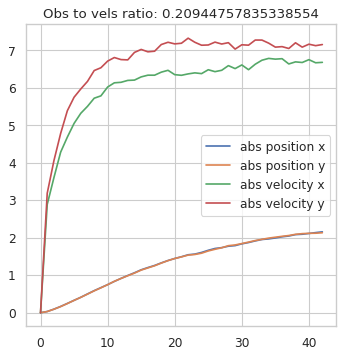

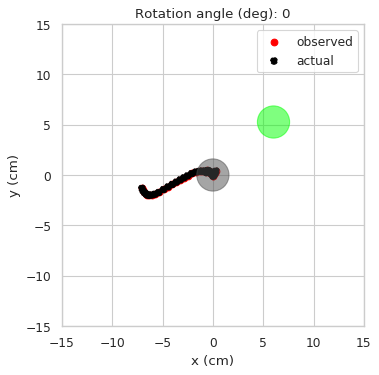

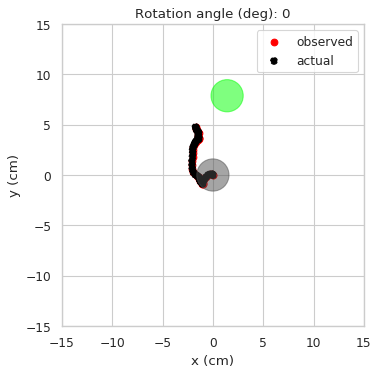

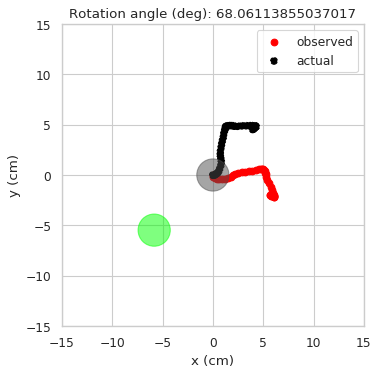

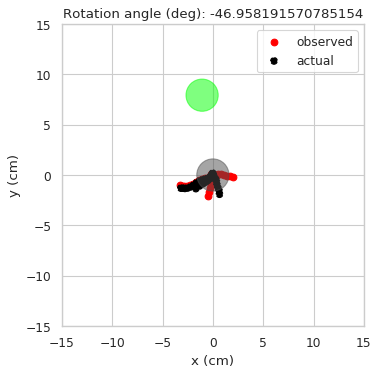

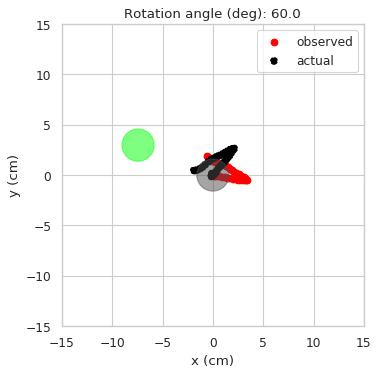

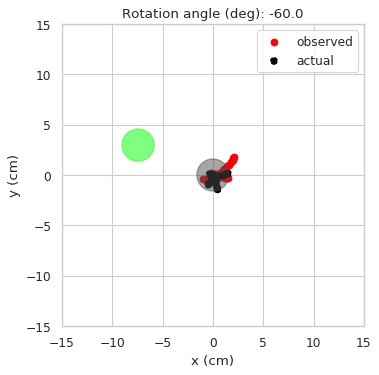

In [15]:
### plot some example trajectories as a sanity check
plt.close('all')
traj_num = 6

### change this line if you want to check data in another folder
data_dir = data_dir

plot_obs_vels(os.path.join(data_dir,'train_data_original.pkl'))

plot_trajectory(os.path.join(data_dir,'train_data_original.pkl'),traj_num)
plot_trajectory(os.path.join(data_dir,'val_data_original.pkl'),traj_num)


plot_trajectory(os.path.join(data_dir,'train_data_rot.pkl'),traj_num)
plot_trajectory(os.path.join(data_dir,'val_data_rot.pkl'),traj_num)

plot_trajectory(os.path.join(data_dir,'train_data_rot_plus.pkl'),traj_num)
plot_trajectory(os.path.join(data_dir,'val_data_rot_plus.pkl'),traj_num)